### 0. Setup Workbook

In [54]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook


# Load the SQL query from the file
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    snowhook = SnowflakeHook()
    df = snowhook.query_snowflake(query, method='pandas')

    # format decimal to float
    for col in df.columns:
        if df[col].dtype == 'object' and isinstance(df[col].dropna().iloc[0], Decimal):
            df[col] = df[col].astype(float)

    return df

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal

### Read Inputs

Import DACO Simulation Results: all_sms_daco_output is the results for Global (SM0), Pittsburgh (SM81), Pittsburgh cohort SMs, and Top SMs

In [56]:
all_sms_daco_output = load_query('all_sms_daco_output.sql')
display(all_sms_daco_output[all_sms_daco_output['submarket_id'] == 0])

2025-09-14 10:02:31,881 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-14 10:02:31,882 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-14 10:02:32,743 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-14 10:02:32,744 - utils.snowflake_connection - INFO - Executing query (pandas)


,submarket_id,mcpd_scenario,spending,applicants,new_dx,wad,hours
0,0,1000,4.669642e+05,8169.743731,1703.735784,11969.157528,136629.136869
1,0,2000,1.328705e+06,11808.890138,2405.857428,16920.316741,190258.651040
2,0,3000,2.254686e+06,13956.571084,2823.832750,19876.235518,222269.328212
3,0,4000,3.036463e+06,15298.070031,3073.467708,21655.563289,240817.524367
4,0,5000,3.797443e+06,16405.958823,3275.364326,23090.265497,256056.970641
5,0,6000,4.425450e+06,17112.736606,3408.040026,24029.971439,266072.319642
6,0,7000,4.965759e+06,17630.457314,3512.724291,24775.138123,273588.690991
7,0,8000,5.418885e+06,18106.955830,3602.525084,25415.959887,280102.242471
8,0,9000,5.807385e+06,18527.999344,3684.558073,26004.698445,285788.006830
9,0,10000,6.118613e+06,18914.321342,3753.626956,26504.556407,290120.197965


## Global

#### Define Functions

In [57]:
def calculate_cpih(df):
    df = df.copy()

    df['inc_spend'] = df['spending'].diff()
    df.loc[df.index[0], 'inc_spend'] = df['spending'].iloc[0]

    df['inc_applicants'] = df['applicants'].diff()
    df.loc[df.index[0], 'inc_applicants'] = df['applicants'].iloc[0]

    df['inc_new_dx'] = df['new_dx'].diff()
    df.loc[df.index[0], 'inc_new_dx'] = df['new_dx'].iloc[0]

    df['inc_wad'] = df['wad'].diff()
    df.loc[df.index[0], 'inc_wad'] = df['wad'].iloc[0]

    df['inc_hours'] = df['hours'].diff()
    df.loc[df.index[0], 'inc_hours'] = df['hours'].iloc[0]

    df['inc_hours_lifetime'] = df['inc_new_dx'] * 170

    df['cpih'] = df['inc_spend'] / (df['inc_hours'] * 1.2)
    ## why adjust for cpih
    # DACO applied a more aggressive churn rate of new dx than the actual churn rate, on avg 20% higher

    df['cpih_lifetime'] = df['inc_spend'] / df['inc_hours_lifetime']

    df['cpiwad'] = df['inc_spend'] / df['inc_wad']
    df['actual_mcpd'] = df['inc_spend'] / df['inc_new_dx']

    return df


In [58]:
def _r2_fast(y, yhat):
    """Fast R² on numpy arrays (returns -inf if y is constant)."""
    ss_tot = np.square(y - y.mean()).sum()
    if ss_tot == 0:
        return -np.inf
    ss_res = np.square(y - yhat).sum()
    return 1 - ss_res / ss_tot


def _pick_scale_sat_exp(x, y, grid=None):
    """Grid-search the saturating-exponential *scale* that maximises OLS R²."""
    x = x.astype(float)
    y = y.astype(float)

    if grid is None:
        x_pos = x[x > 0]
        x_max = x_pos.max()
        x_med = np.median(x_pos)
        s_min = 1.0 / (10 * x_max)
        s_max = 10.0 / x_med
        grid = np.geomspace(s_min, s_max, 25)

    best_s, best_r2 = None, -np.inf
    for s in grid:
        tr = 1.0 - np.exp(-s * x)
        X = np.vstack([np.ones_like(tr), tr]).T
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        r2 = _r2_fast(y, X @ beta)
        if r2 > best_r2:
            best_r2, best_s = r2, s

    return best_s if best_s is not None else 1.0


# ---------- Regression runner ----------

def run_regression(df, y, x, *, kind="linear", weights=None, bin_column=None, **kwargs):
    """Fit one curve shape via GLM and return summary, prediction df, and coefficients."""
    work = df.copy()

    if kind == "linear":
        reg = x
        formula = f"{y} ~ {reg}"

    elif kind == "log":
        work["_log_x"] = np.log(work[x].replace(0, np.nan))
        reg = "_log_x"
        formula = f"{y} ~ {reg}"

    elif kind == "log_shift":
        shift = kwargs.get("shift", 1.0)
        work["_log_xs"] = np.log(work[x] + shift)
        reg = "_log_xs"
        formula = f"{y} ~ {reg}"

    elif kind == "exp":
        scale = kwargs.get("scale")
        if scale is None:
            xmax = np.nanmax(work[x].values)
            scale = xmax / 10 if xmax > 0 else 1.0
            print(f"[run_regression] Auto-selected scale={scale:.4g} for exp")
        work["_exp_x"] = np.exp(work[x] / scale)
        reg = "_exp_x"
        formula = f"{y} ~ {reg}"

    elif kind == "power":
        p = kwargs.get("p", 2.0)
        work["_pow_x"] = np.power(work[x], p)
        reg = "_pow_x"
        formula = f"{y} ~ {reg}"

    elif kind == "quadratic":
        work["_x2"] = np.square(work[x])
        reg = ["_x2", x]
        formula = f"{y} ~ {x} + _x2"

    elif kind == "sat_exp":
        scale = kwargs.get("scale")
        if scale is None:
            finite_mask = np.isfinite(work[[x, y]]).all(axis=1)
            scale = _pick_scale_sat_exp(work.loc[finite_mask, x].values,
                                        work.loc[finite_mask, y].values)
            print(f"[run_regression] Auto-selected scale={scale:.4g} for sat_exp")
        work["_sat_x"] = 1.0 - np.exp(-scale * work[x])
        reg = "_sat_x"
        formula = f"{y} ~ {reg}"

    elif kind == "hill":
        h = kwargs.get("h", 1.0)
        k_param = kwargs.get("k", 1.0)
        work["_hill_x"] = (work[x] ** h) / (k_param ** h + work[x] ** h)
        reg = "_hill_x"
        formula = f"{y} ~ {reg}"

    else:
        raise ValueError("Unsupported kind: " + kind)

    # Clean rows
    mask = np.isfinite(work[[y] + ([reg] if isinstance(reg, str) else reg)]).all(axis=1)
    if (d := len(work) - mask.sum()) > 0:
        print(f"[run_regression] Dropped {d} non-finite rows for '{kind}'.")
    work = work.loc[mask]
    if len(work) < 3:
        raise ValueError(f"Not enough observations for kind='{kind}'.")

    # Fit model
    model = smf.glm(formula=formula, data=work,
                    var_weights=weights.loc[work.index] if weights is not None else None).fit()
    params = model.params

    # Pretty formulas
    if kind == "linear":
        fstr = f"{y} = {params[x]:.10f}·{x} + {params['Intercept']:.10f}"
    elif kind == "log":
        fstr = f"{y} = {params['_log_x']:.10f}·ln({x}) + {params['Intercept']:.10f}"
    elif kind == "log_shift":
        fstr = f"{y} = {params['_log_xs']:.10f}·ln({x} + {shift}) + {params['Intercept']:.10f}"
    elif kind == "exp":
        fstr = f"{y} = {params['_exp_x']:.10f}·exp({x}/{scale:.3g}) + {params['Intercept']:.10f}"
    elif kind == "power":
        fstr = f"{y} = {params['_pow_x']:.10f}·({x}^{p}) + {params['Intercept']:.10f}"
    elif kind == "quadratic":
        fstr = f"{y} = {params['_x2']:.10f}·{x}² + {params[x]:.3f}·{x} + {params['Intercept']:.10f}"
    elif kind == "sat_exp":
        fstr = f"{y} = {params['_sat_x']:.10f}·(1 − exp(−{scale:.3g}·{x})) + {params['Intercept']:.10f}"
    else:  # hill
        h = kwargs.get("h", 1.0); k_param = kwargs.get("k", 1.0)
        fstr = f"{y} = {params['_hill_x']:.10f}·({x}^{h})/({k_param}^{h} + {x}^{h}) + {params['Intercept']:.10f}"

    # Pseudo R² fallback
    r2 = getattr(model, "prsquared", 1 - model.deviance / model.null_deviance)

    # Predictions
    x_fit = np.linspace(df[x].min(), df[x].max(), 500)
    pred_df = pd.DataFrame({x: x_fit})

    if kind == "linear":
        pass
    elif kind == "log":
        pred_df["_log_x"] = np.log(pred_df[x])
    elif kind == "log_shift":
        pred_df["_log_xs"] = np.log(pred_df[x] + shift)
    elif kind == "exp":
        pred_df["_exp_x"] = np.exp(pred_df[x] / scale)
    elif kind == "power":
        pred_df["_pow_x"] = np.power(pred_df[x], p)
    elif kind == "quadratic":
        pred_df["_x2"] = np.square(pred_df[x])
    elif kind == "sat_exp":
        pred_df["_sat_x"] = 1.0 - np.exp(-scale * pred_df[x])
    else:  # hill
        pred_df["_hill_x"] = (pred_df[x] ** h) / (k_param ** h + pred_df[x] ** h)

    y_fit = model.predict(pred_df)
    pred_df[y] = y_fit


    # Build summary with normalized coefficient names
    coef_dict = params.to_dict()
    if x in coef_dict:  # rename the main predictor to "x_col"
        coef_dict["x_col"] = coef_dict.pop(x)

    summary = pd.DataFrame({
        "kind": [kind],
        "formula": [fstr],
        "r2": [round(r2, 4)],
        **{coef: [val] for coef, val in coef_dict.items()}
    })


    # Plot
    import seaborn as sns
    plt.figure(figsize=(7, 4))
    if bin_column and bin_column in df.columns:
        unique_bins = df[bin_column].dropna().unique()
        palette = sns.color_palette("tab10", len(unique_bins))
        bin_color_map = dict(zip(unique_bins, palette))
        colors = df[bin_column].map(bin_color_map)
        plt.scatter(df[x], df[y], c=colors, alpha=0.5)
        for label, color in bin_color_map.items():
            plt.scatter([], [], c=[color], label=str(label))
    else:
        plt.scatter(df[x], df[y], alpha=0.5, label="Actual")

    plt.plot(x_fit, y_fit, "r-", label=f"{kind} (R²={r2:.3f})")
    plt.title(f"{kind.replace('_', ' ').title()} fit: {y} vs {x}")
    plt.xlabel(x); plt.ylabel(y)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # summary = pd.DataFrame({"metric": [y], "formula": [fstr], "r2": [round(r2, 4)]})

    return summary, pred_df


# ---------- Fit multiple shapes ----------

def fit_all_curves(df, x_col, y_col, *, shapes=None, weights=None, bin_columns=None, **per_shape_kwargs):
    """Fit multiple curve shapes and summarise results.
       Returns: (best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df)
    """
    if shapes is None:
        shapes = SHAPES

    results = []
    fitted_dfs = {}
    summaries = []

    for kind in shapes:
        kw = per_shape_kwargs.get(kind, {})
        try:
            summ, pred_df = run_regression(df, y_col, x_col, kind=kind,
                                           weights=weights, bin_column=bin_columns, **kw)
            results.append((kind, summ.loc[0, "formula"], summ.loc[0, "r2"]))
            fitted_dfs[kind] = pred_df
            summaries.append(summ)
        except Exception as err:
            print(f"[{kind}] FAILED → {err}")
            results.append((kind, None, -np.inf))
            fitted_dfs[kind] = None

    results_df = pd.DataFrame(results, columns=["kind", "formula", "r2"])
    coef_df = pd.concat(summaries, ignore_index=True) if summaries else pd.DataFrame()

    # Pick best model
    best_kind, best_formula, best_r2 = max(results, key=lambda t: t[2])
    if best_formula is not None:
        print(f"\nBest Model → {best_kind}  (R²={best_r2:.4f})")
        best_fit_df = fitted_dfs[best_kind]
    else:
        print("\nNo model fit succeeded.")
        best_fit_df = None

    return best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df



In [59]:
# def _r2_fast(y, yhat):
#     """Fast R² on numpy arrays (returns -inf if y is constant)."""
#     ss_tot = np.square(y - y.mean()).sum()
#     if ss_tot == 0:
#         return -np.inf
#     ss_res = np.square(y - yhat).sum()
#     return 1 - ss_res / ss_tot


# def _pick_scale_sat_exp(x, y, grid=None):
#     """Grid-search the saturating-exponential *scale* that maximises ordinary-least-squares R²."""
#     x = x.astype(float)
#     y = y.astype(float)

#     if grid is None:
#         x_pos = x[x > 0]
#         x_max = x_pos.max()
#         x_med = np.median(x_pos)
#         s_min = 1.0 / (10 * x_max)
#         s_max = 10.0 / x_med
#         grid = np.geomspace(s_min, s_max, 25)

#     best_s, best_r2 = None, -np.inf
#     for s in grid:
#         tr = 1.0 - np.exp(-s * x)
#         X = np.vstack([np.ones_like(tr), tr]).T
#         beta = np.linalg.lstsq(X, y, rcond=None)[0]
#         r2 = _r2_fast(y, X @ beta)
#         if r2 > best_r2:
#             best_r2, best_s = r2, s

#     return best_s if best_s is not None else 1.0


# def run_regression(df, y, x, *, kind="linear", weights=None, bin_column=None, **kwargs):
#     """Fit one curve shape via GLM and plot with a unified styling.
#        Returns (summary_df, pred_df)
#     """
#     work = df.copy()

#     if kind == "linear":
#         reg = x
#         formula = f"{y} ~ {reg}"

#     elif kind == "log":
#         work["_log_x"] = np.log(work[x].replace(0, np.nan))
#         reg = "_log_x"
#         formula = f"{y} ~ {reg}"

#     elif kind == "log_shift":
#         shift = kwargs.get("shift", 1.0)
#         work["_log_xs"] = np.log(work[x] + shift)
#         reg = "_log_xs"
#         formula = f"{y} ~ {reg}"

#     elif kind == "exp":
#         scale = kwargs.get("scale")
#         if scale is None:
#             xmax = np.nanmax(work[x].values)
#             scale = xmax / 10 if xmax > 0 else 1.0
#             print(f"[run_regression] Auto-selected scale={scale:.4g} for exp")
#         work["_exp_x"] = np.exp(work[x] / scale)
#         reg = "_exp_x"
#         formula = f"{y} ~ {reg}"

#     elif kind == "power":
#         p = kwargs.get("p", 2.0)
#         work["_pow_x"] = np.power(work[x], p)
#         reg = "_pow_x"
#         formula = f"{y} ~ {reg}"

#     elif kind == "quadratic":
#         work["_x2"] = np.square(work[x])
#         reg = ["_x2", x]
#         formula = f"{y} ~ {x} + _x2"

#     elif kind == "sat_exp":
#         scale = kwargs.get("scale")
#         if scale is None:
#             finite_mask = np.isfinite(work[[x, y]]).all(axis=1)
#             scale = _pick_scale_sat_exp(work.loc[finite_mask, x].values,
#                                         work.loc[finite_mask, y].values)
#             print(f"[run_regression] Auto-selected scale={scale:.4g} for sat_exp")
#         work["_sat_x"] = 1.0 - np.exp(-scale * work[x])
#         reg = "_sat_x"
#         formula = f"{y} ~ {reg}"

#     elif kind == "hill":
#         h = kwargs.get("h", 1.0)
#         k_param = kwargs.get("k", 1.0)
#         work["_hill_x"] = (work[x] ** h) / (k_param ** h + work[x] ** h)
#         reg = "_hill_x"
#         formula = f"{y} ~ {reg}"

#     else:
#         raise ValueError("Unsupported kind: " + kind)

#     # Clean rows
#     mask = np.isfinite(work[[y] + ([reg] if isinstance(reg, str) else reg)]).all(axis=1)
#     if (d := len(work) - mask.sum()) > 0:
#         print(f"[run_regression] Dropped {d} non-finite rows for '{kind}'.")
#     work = work.loc[mask]
#     if len(work) < 3:
#         raise ValueError(f"Not enough observations for kind='{kind}'.")

#     # Fit model
#     model = smf.glm(formula=formula, data=work,
#                     var_weights=weights.loc[work.index] if weights is not None else None).fit()
#     params = model.params

#     # Pretty formulas
#     if kind == "linear":
#         fstr = f"{y} = {params[x]:.10f}·{x} + {params['Intercept']:.10f}"
#     elif kind == "log":
#         fstr = f"{y} = {params['_log_x']:.10f}·ln({x}) + {params['Intercept']:.10f}"
#     elif kind == "log_shift":
#         fstr = f"{y} = {params['_log_xs']:.10f}·ln({x} + {shift}) + {params['Intercept']:.10f}"
#     elif kind == "exp":
#         fstr = f"{y} = {params['_exp_x']:.10f}·exp({x}/{scale:.3g}) + {params['Intercept']:.10f}"
#     elif kind == "power":
#         fstr = f"{y} = {params['_pow_x']:.10f}·({x}^{p}) + {params['Intercept']:.10f}"
#     elif kind == "quadratic":
#         fstr = f"{y} = {params['_x2']:.10f}·{x}² + {params[x]:.3f}·{x} + {params['Intercept']:.10f}"
#     elif kind == "sat_exp":
#         fstr = f"{y} = {params['_sat_x']:.10f}·(1 − exp(−{scale:.3g}·{x})) + {params['Intercept']:.10f}"
#     else:  # hill
#         h = kwargs.get("h", 1.0); k_param = kwargs.get("k", 1.0)
#         fstr = f"{y} = {params['_hill_x']:.10f}·({x}^{h})/({k_param}^{h} + {x}^{h}) + {params['Intercept']:.10f}"

#     # Pseudo R² fallback
#     r2 = getattr(model, "prsquared", 1 - model.deviance / model.null_deviance)

#     # Predictions
#     x_fit = np.linspace(df[x].min(), df[x].max(), 500)
#     pred_df = pd.DataFrame({x: x_fit})

#     if kind == "linear":
#         pass
#     elif kind == "log":
#         pred_df["_log_x"] = np.log(pred_df[x])
#     elif kind == "log_shift":
#         pred_df["_log_xs"] = np.log(pred_df[x] + shift)
#     elif kind == "exp":
#         pred_df["_exp_x"] = np.exp(pred_df[x] / scale)
#     elif kind == "power":
#         pred_df["_pow_x"] = np.power(pred_df[x], p)
#     elif kind == "quadratic":
#         pred_df["_x2"] = np.square(pred_df[x])
#     elif kind == "sat_exp":
#         pred_df["_sat_x"] = 1.0 - np.exp(-scale * pred_df[x])
#     else:  # hill
#         pred_df["_hill_x"] = (pred_df[x] ** h) / (k_param ** h + pred_df[x] ** h)

#     y_fit = model.predict(pred_df)
#     pred_df[y] = y_fit

#     # Plot
#     import seaborn as sns
#     plt.figure(figsize=(7, 4))
#     if bin_column and bin_column in df.columns:
#         unique_bins = df[bin_column].dropna().unique()
#         palette = sns.color_palette("tab10", len(unique_bins))
#         bin_color_map = dict(zip(unique_bins, palette))
#         colors = df[bin_column].map(bin_color_map)
#         plt.scatter(df[x], df[y], c=colors, alpha=0.5)
#         for label, color in bin_color_map.items():
#             plt.scatter([], [], c=[color], label=str(label))
#     else:
#         plt.scatter(df[x], df[y], alpha=0.5, label="Actual")

#     plt.plot(x_fit, y_fit, "r-", label=f"{kind} (R²={r2:.3f})")
#     plt.title(f"{kind.replace('_', ' ').title()} fit: {y} vs {x}")
#     plt.xlabel(x); plt.ylabel(y)
#     plt.legend()
#     plt.grid(True, linestyle="--", alpha=0.5)
#     plt.tight_layout()
#     plt.show()

#     summary = pd.DataFrame({"metric": [y], "formula": [fstr], "r2": [round(r2, 4)]})
#     return summary, pred_df


# def fit_all_curves(df, x_col, y_col, *, shapes=None, weights=None, bin_columns=None, **per_shape_kwargs):
#     """Fit multiple curve shapes and summarise the results.
#        Returns: (best_kind, best_formula, best_r2, results_df, best_fit_df)
#     """
#     if shapes is None:
#         shapes = SHAPES

#     results = []
#     fitted_dfs = {}

#     for kind in shapes:
#         kw = per_shape_kwargs.get(kind, {})
#         try:
#             summ, pred_df = run_regression(df, y_col, x_col, kind=kind,
#                                            weights=weights, bin_column=bin_columns, **kw)
#             formula = summ.loc[0, "formula"]
#             r2 = summ.loc[0, "r2"]
#             results.append((kind, formula, r2))
#             fitted_dfs[kind] = pred_df
#         except Exception as err:
#             print(f"[{kind}] FAILED → {err}")
#             results.append((kind, None, -np.inf))
#             fitted_dfs[kind] = None

#     results_df = pd.DataFrame(results, columns=["kind", "formula", "r2"])

#     print("\nFitted Models:")
#     for kind, formula, r2 in results:
#         if formula is not None:
#             print(f"{kind:<10}: {formula}   (R²={r2:.4f})")
#         else:
#             print(f"{kind:<10}: <failed>")

#     best_kind, best_formula, best_r2 = max(results, key=lambda t: t[2])
#     if best_formula is not None:
#         print(f"\nBest Model → {best_kind}  (R²={best_r2:.4f})")
#         best_fit_df = fitted_dfs[best_kind]
#     else:
#         print("\nNo model fit succeeded.")
#         best_fit_df = None

#     return best_kind, best_formula, best_r2, results_df, best_fit_df


#### SM0

In [60]:
df_sm0 = all_sms_daco_output[all_sms_daco_output['submarket_id'] == 0]
df_sm0_calc = calculate_cpih(df_sm0)
df_sm0_calc['avg_cpih'] = df_sm0_calc['spending'] / df_sm0_calc['hours']
df_sm0_calc['avg_cpwad'] = df_sm0_calc['spending'] / df_sm0_calc['wad']
df_sm0_calc['hours_per_dx'] = df_sm0_calc['hours'] / df_sm0_calc['wad']
df_sm0_calc

,submarket_id,mcpd_scenario,spending,applicants,new_dx,wad,hours,inc_spend,inc_applicants,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd,avg_cpih,avg_cpwad,hours_per_dx
0,0,1000,4.669642e+05,8169.743731,1703.735784,11969.157528,136629.136869,466964.214273,8169.743731,1703.735784,11969.157528,136629.136869,289635.083227,2.848125,1.612250,39.013958,274.082530,3.417750,39.013958,11.415101
1,0,2000,1.328705e+06,11808.890138,2405.857428,16920.316741,190258.651040,861740.667110,3639.146407,702.121644,4951.159213,53629.514172,119360.679489,13.390336,7.219636,174.048264,1227.338132,6.983677,78.527187,11.244391
2,0,3000,2.254686e+06,13956.571084,2823.832750,19876.235518,222269.328212,925980.824683,2147.680946,417.975322,2955.918777,32010.677171,71055.804786,24.106041,13.031741,313.263285,2215.395923,10.143935,113.436254,11.182667
3,0,4000,3.036463e+06,15298.070031,3073.467708,21655.563289,240817.524367,781777.335867,1341.498947,249.634958,1779.327771,18548.196155,42437.942788,35.123691,18.421660,439.366680,3131.682131,12.608979,140.216304,11.120354
4,0,5000,3.797443e+06,16405.958823,3275.364326,23090.265497,256056.970641,760979.724742,1107.888791,201.896618,1434.702208,15239.446274,34322.425104,41.612389,22.171502,530.409531,3769.155379,14.830460,164.460767,11.089390
5,0,6000,4.425450e+06,17112.736606,3408.040026,24029.971439,266072.319642,628007.121212,706.777783,132.675700,939.705942,10015.349001,22554.868981,52.253723,27.843528,668.301745,4733.399724,16.632508,184.163760,11.072519
6,0,7000,4.965759e+06,17630.457314,3512.724291,24775.138123,273588.690991,540308.945270,517.720708,104.684265,745.166684,7516.371349,17796.325069,59.903567,30.360703,725.084678,5161.319561,18.150454,200.433144,11.042872
7,0,8000,5.418885e+06,18106.955830,3602.525084,25415.959887,280102.242471,453125.915792,476.498516,89.800793,640.821763,6513.551480,15266.134884,57.972203,29.681771,707.101322,5045.901027,19.346096,213.207952,11.020723
8,0,9000,5.807385e+06,18527.999344,3684.558073,26004.698445,285788.006830,388500.293233,421.043514,82.032989,588.738559,5685.764359,13945.608058,56.940496,27.858254,659.885933,4735.903201,20.320604,223.320607,10.989860
9,0,10000,6.118613e+06,18914.321342,3753.626956,26504.556407,290120.197965,311227.886167,386.321999,69.068883,499.857962,4332.191136,11741.710076,59.867297,26.506180,622.632647,4506.050678,21.089924,230.851361,10.946050


In [61]:
df_sm0_calc_output = df_sm0_calc[['actual_mcpd', 'spending','applicants', 'new_dx', 'hours', 'wad','cpih','cpih_lifetime', 'avg_cpih', 'avg_cpwad', 'hours_per_dx']]
df_sm0_calc_output

,actual_mcpd,spending,applicants,new_dx,hours,wad,cpih,cpih_lifetime,avg_cpih,avg_cpwad,hours_per_dx
0,274.082530,4.669642e+05,8169.743731,1703.735784,136629.136869,11969.157528,2.848125,1.612250,3.417750,39.013958,11.415101
1,1227.338132,1.328705e+06,11808.890138,2405.857428,190258.651040,16920.316741,13.390336,7.219636,6.983677,78.527187,11.244391
2,2215.395923,2.254686e+06,13956.571084,2823.832750,222269.328212,19876.235518,24.106041,13.031741,10.143935,113.436254,11.182667
3,3131.682131,3.036463e+06,15298.070031,3073.467708,240817.524367,21655.563289,35.123691,18.421660,12.608979,140.216304,11.120354
4,3769.155379,3.797443e+06,16405.958823,3275.364326,256056.970641,23090.265497,41.612389,22.171502,14.830460,164.460767,11.089390
5,4733.399724,4.425450e+06,17112.736606,3408.040026,266072.319642,24029.971439,52.253723,27.843528,16.632508,184.163760,11.072519
6,5161.319561,4.965759e+06,17630.457314,3512.724291,273588.690991,24775.138123,59.903567,30.360703,18.150454,200.433144,11.042872
7,5045.901027,5.418885e+06,18106.955830,3602.525084,280102.242471,25415.959887,57.972203,29.681771,19.346096,213.207952,11.020723
8,4735.903201,5.807385e+06,18527.999344,3684.558073,285788.006830,26004.698445,56.940496,27.858254,20.320604,223.320607,10.989860
9,4506.050678,6.118613e+06,18914.321342,3753.626956,290120.197965,26504.556407,59.867297,26.506180,21.089924,230.851361,10.946050


In [62]:
sm_bucket = load_query('top_sm.sql') # bad naming - this is actually the market facts

2025-09-14 10:02:33,733 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-14 10:02:33,734 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-14 10:02:34,239 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-14 10:02:34,240 - utils.snowflake_connection - INFO - Executing query (pandas)


In [63]:
df_global = all_sms_daco_output[all_sms_daco_output['submarket_id']!= 0].copy() # drop global SM itself
df_global = df_global.merge(sm_bucket[['submarket_id','total_deliveries']], on='submarket_id', how='left').fillna(0) # join to get market facts

df_calc = df_global.groupby('submarket_id').apply(lambda x: calculate_cpih(x))
df_calc = df_calc.reset_index(drop=True)

exclude_sms = df_calc[df_calc['inc_applicants'] < 0]['submarket_id'].unique().tolist() + df_calc[df_calc['inc_new_dx'] < 0]['submarket_id'].unique().tolist() + df_calc[df_calc['cpih'] > 120]['submarket_id'].unique().tolist()    
df_calc = df_calc[~df_calc['submarket_id'].isin(exclude_sms)]

def wavg(group, cols, weight_col="tot_delivs"):
    d = group[cols]
    w = group[weight_col]
    return (d.mul(w, axis=0).sum(axis=0)) / w.sum()

# Columns you want to aggregate
agg_cols = [
    'spending','applicants','new_dx','wad','hours','total_deliveries'
]

df_global_weighted = (
    df_calc
    .groupby("mcpd_scenario")
    .apply(lambda g: wavg(g, agg_cols, weight_col="spending"))
    # .apply(lambda g: wavg(g, agg_cols, weight_col="total_deliveries"))
    .reset_index()
)

df_global_weighted

,mcpd_scenario,spending,applicants,new_dx,wad,hours,total_deliveries
0,1000,8295.523519,168.520618,36.737882,256.850021,2903.899746,412562.579916
1,2000,21479.936334,218.634761,46.612347,326.740374,3710.710552,395627.435308
2,3000,39244.486515,260.958658,55.746151,390.479974,4433.447302,398499.588897
3,4000,55423.930907,291.712849,61.856650,433.456016,4930.723688,395479.051694
4,5000,71401.596361,316.414170,67.202445,470.347847,5349.920716,396692.527610
5,6000,84717.116551,332.600037,70.588177,493.855703,5621.165949,398241.012583
6,7000,96279.035543,345.577447,73.410209,513.268872,5840.885110,398341.520338
7,8000,104871.930485,354.581058,75.184082,525.662599,5980.558573,396813.602380
8,9000,111815.534635,361.078388,76.344833,533.785547,6075.365195,395621.951561
9,10000,117899.205277,365.898012,77.117855,539.337732,6142.093932,395506.230613


In [64]:
df_global_weighted = df_global_weighted.merge(df_sm0_calc[['mcpd_scenario','spending','applicants']], on='mcpd_scenario', how='left', suffixes=('', '_sm0'))

df_global_weighted = calculate_cpih(df_global_weighted)
df_global_weighted['spending_ratio'] = df_global_weighted['spending'] / df_global_weighted['spending_sm0']
df_global_weighted['spending_scaled'] = df_global_weighted['applicants_sm0'] / df_global_weighted['applicants'] * df_global_weighted['spending']

df_global_weighted

,mcpd_scenario,spending,applicants,new_dx,wad,hours,total_deliveries,spending_sm0,applicants_sm0,inc_spend,...,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd,spending_ratio,spending_scaled
0,1000,8295.523519,168.520618,36.737882,256.850021,2903.899746,412562.579916,4.669642e+05,8169.743731,8295.523519,...,36.737882,256.850021,2903.899746,6245.439968,2.380570,1.328253,32.297149,225.802987,0.017765,4.021603e+05
1,2000,21479.936334,218.634761,46.612347,326.740374,3710.710552,395627.435308,1.328705e+06,11808.890138,13184.412815,...,9.874465,69.890353,806.810806,1678.659084,13.617828,7.854134,188.644244,1335.202722,0.016166,1.160173e+06
2,3000,39244.486515,260.958658,55.746151,390.479974,4433.447302,398499.588897,2.254686e+06,13956.571084,17764.550181,...,9.133804,63.739600,722.736750,1552.746687,20.482965,11.440727,278.705077,1944.923507,0.017406,2.098871e+06
3,4000,55423.930907,291.712849,61.856650,433.456016,4930.723688,395479.051694,3.036463e+06,15298.070031,16179.444391,...,6.110499,42.976042,497.276386,1038.784813,27.113434,15.575357,376.475908,2647.810703,0.018253,2.906554e+06
4,5000,71401.596361,316.414170,67.202445,470.347847,5349.920716,396692.527610,3.797443e+06,16405.958823,15977.665455,...,5.345795,36.891831,419.197028,908.785156,31.762442,17.581345,433.094940,2988.828667,0.018803,3.702147e+06
5,6000,84717.116551,332.600037,70.588177,493.855703,5621.165949,398241.012583,4.425450e+06,17112.736606,13315.520189,...,3.385732,23.507856,271.245233,575.574460,40.908615,23.134314,566.428524,3932.833351,0.019143,4.358814e+06
6,7000,96279.035543,345.577447,73.410209,513.268872,5840.885110,398341.520338,4.965759e+06,17630.457314,11561.918993,...,2.822031,19.413168,219.719161,479.745342,43.851126,24.100117,595.570946,4097.019929,0.019389,4.911905e+06
7,8000,104871.930485,354.581058,75.184082,525.662599,5980.558573,396813.602380,5.418885e+06,18106.955830,8592.894941,...,1.773873,12.393728,139.673463,301.558421,51.267762,28.494959,693.326106,4844.143085,0.019353,5.355366e+06
8,9000,111815.534635,361.078388,76.344833,533.785547,6075.365195,395621.951561,5.807385e+06,18527.999344,6943.604151,...,1.160751,8.122948,94.806622,197.327692,61.033044,35.188189,854.813311,5981.992165,0.019254,5.737586e+06
9,10000,117899.205277,365.898012,77.117855,539.337732,6142.093932,395506.230613,6.118613e+06,18914.321342,6083.670642,...,0.773022,5.552184,66.728737,131.413804,75.975146,46.294000,1095.725606,7869.980027,0.019269,6.094549e+06


In [102]:
# adjust for applicants forecast inaccuracy
apps_forecast_adjustment = 2.54
hours_forecast_adjustment = 1.47
wad_forecast_adjustment = 1.47

# apps_forecast_adjustment = 1
# hours_forecast_adjustment = 1
# wad_forecast_adjustment = 1

df_global_weighted['applicants'] = df_global_weighted['applicants'] * apps_forecast_adjustment
df_global_weighted['new_dx'] = df_global_weighted['new_dx'] * apps_forecast_adjustment
df_global_weighted['hours'] = df_global_weighted['hours'] * hours_forecast_adjustment
df_global_weighted['wad'] = df_global_weighted['wad'] * wad_forecast_adjustment

df_global_weighted

,mcpd_scenario,spending,applicants,new_dx,wad,hours,total_deliveries,spending_sm0,applicants_sm0,inc_spend,...,cpih_lifetime,cpiwad,actual_mcpd,spending_ratio,spending_scaled,avg_cpa,avg_cpih,avg_cpwad,hours_per_dx,avg_cpd
0,1000,8295.523519,428.042370,93.314221,377.569531,4268.732627,412562.579916,4.669642e+05,8169.743731,8295.523519,...,1.328253,32.297149,225.802987,0.017765,4.021603e+05,49.225570,2.856684,32.297149,11.305819,225.802987
1,2000,21479.936334,555.332294,118.395362,480.308350,5454.744511,395627.435308,1.328705e+06,11808.890138,13184.412815,...,7.854134,188.644244,1335.202722,0.016166,1.160173e+06,98.245751,5.788632,65.740074,11.356756,460.820738
2,3000,39244.486515,662.834990,141.595225,574.005562,6517.167533,398499.588897,2.254686e+06,13956.571084,17764.550181,...,11.440727,278.705077,1944.923507,0.017406,2.098871e+06,150.385838,8.851912,100.503199,11.353840,703.985576
3,4000,55423.930907,740.950637,157.115892,637.180344,7248.163821,395479.051694,3.036463e+06,15298.070031,16179.444391,...,15.575357,376.475908,2647.810703,0.018253,2.906554e+06,189.994822,11.240527,127.865179,11.375373,896.006018
4,5000,71401.596361,803.691993,170.694211,691.411336,7864.383453,396692.527610,3.797443e+06,16405.958823,15977.665455,...,17.581345,433.094940,2988.828667,0.018803,3.702147e+06,225.658656,13.346291,151.805938,11.374392,1062.485093
5,6000,84717.116551,844.804095,179.293971,725.967884,8263.113946,398241.012583,4.425450e+06,17112.736606,13315.520189,...,23.134314,566.428524,3932.833351,0.019143,4.358814e+06,254.711687,15.071093,171.542246,11.382203,1200.160134
6,7000,96279.035543,877.766716,186.461931,754.505241,8586.101112,398341.520338,4.965759e+06,17630.457314,11561.918993,...,24.100117,595.570946,4097.019929,0.019389,4.911905e+06,278.603353,16.483638,187.580118,11.379777,1311.521068
7,8000,104871.930485,900.635888,190.967568,772.724021,8791.421102,396813.602380,5.418885e+06,18106.955830,8592.894941,...,28.494959,693.326106,4844.143085,0.019353,5.355366e+06,295.762924,17.535474,199.504265,11.377181,1394.868804
8,9000,111815.534635,917.139105,193.915876,784.664755,8930.786837,395621.951561,5.807385e+06,18527.999344,6943.604151,...,35.188189,854.813311,5981.992165,0.019254,5.737586e+06,309.671081,18.404743,209.476512,11.381659,1464.611685
9,10000,117899.205277,929.380951,195.879353,792.826466,9028.878080,395506.230613,6.118613e+06,18914.321342,6083.670642,...,46.294000,1095.725606,7869.980027,0.019269,6.094549e+06,322.218764,19.195279,218.599958,11.388215,1528.818515


In [103]:
df_global_weighted['avg_cpa'] = df_global_weighted['spending'] / df_global_weighted['applicants']
df_global_weighted['avg_cpih'] = df_global_weighted['spending'] / df_global_weighted['hours']
df_global_weighted['avg_cpwad'] = df_global_weighted['spending'] / df_global_weighted['wad']
df_global_weighted['hours_per_dx'] = df_global_weighted['hours'] / df_global_weighted['wad']
df_global_weighted['avg_cpd'] = df_global_weighted['spending'] / df_global_weighted['new_dx']

df_global_weighted_output = df_global_weighted[['mcpd_scenario', 'actual_mcpd', 'spending_scaled', 'cpih','cpih_lifetime', 'avg_cpih', 'avg_cpwad', 'hours_per_dx', 'avg_cpa', 'avg_cpd']]
df_global_weighted_output['applicants'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpa']
df_global_weighted_output['new_dx'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpd']
df_global_weighted_output['wad'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpwad']
df_global_weighted_output['hours'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpih']
ddf_global_weighted_output = df_global_weighted_output[['mcpd_scenario','actual_mcpd', 'spending_scaled','applicants', 'new_dx', 'hours', 'wad','cpih','cpih_lifetime', 'avg_cpih', 'avg_cpwad', 'hours_per_dx', 'avg_cpa', 'avg_cpd']]


# df_sm0_calc_output = df_sm0_calc[['actual_mcpd', 'spending','applicants', 'new_dx', 'hours', 'wad','cpih','cpih_lifetime', 'avg_cpih', 'avg_cpwad', 'hours_per_dx']]


/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_4288/18387412.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_global_weighted_output['applicants'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpa']
/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_4288/18387412.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_global_weighted_output['new_dx'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpd']
/var/folders/d

In [104]:
df_global_weighted_output['mcpih'] = df_global_weighted_output['spending_scaled'].diff()/df_global_weighted_output['hours'].diff()
df_global_weighted_output['mcpiwad'] = df_global_weighted_output['spending_scaled'].diff()/df_global_weighted_output['wad'].diff()
df_global_weighted_output

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_4288/486618610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_global_weighted_output['mcpih'] = df_global_weighted_output['spending_scaled'].diff()/df_global_weighted_output['hours'].diff()
/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_4288/486618610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_global_weighted_output['mcpiwad'] = df_global_weighted_output['spending_scaled'].diff()/df_global_weighted_output['wad'].diff(

,mcpd_scenario,actual_mcpd,spending_scaled,cpih,cpih_lifetime,avg_cpih,avg_cpwad,hours_per_dx,avg_cpa,avg_cpd,applicants,new_dx,wad,hours,mcpih,mcpiwad
0,1000,225.802987,4.021603e+05,2.380570,1.328253,1.943322,21.970850,11.305819,19.380146,88.898814,20751.149078,4523.798203,18304.266511,206944.716923,NaN,NaN
1,2000,1335.202722,1.160173e+06,13.617828,7.854134,3.937845,44.721139,11.356756,38.679430,181.425488,29994.580951,6394.764570,25942.391319,294621.396145,8.645549,99.240718
2,3000,1944.923507,2.098871e+06,20.482965,11.440727,6.021709,68.369523,11.353840,59.207023,277.159676,35449.690553,7572.785037,30698.921840,348550.658605,17.406086,197.349173
3,4000,2647.810703,2.906554e+06,27.113434,15.575357,7.646617,86.983115,11.375373,74.801111,352.758275,38857.097880,8239.506495,33415.153118,380109.817061,25.592680,297.354447
4,5000,2988.828667,3.702147e+06,31.762442,17.581345,9.079109,103.269346,11.374392,88.841990,418.301218,41671.135409,8850.432320,35849.424481,407765.401128,28.767880,326.829840
5,6000,3932.833351,4.358814e+06,40.908615,23.134314,10.252444,116.695405,11.382203,100.280192,472.503990,43466.350978,9224.925291,37352.061907,425148.757119,37.775640,437.009874
6,7000,4097.019929,4.911905e+06,43.851126,24.100117,11.213359,127.605522,11.379777,109.686360,516.346877,44781.361576,9512.799908,38492.883613,438040.417242,42.902971,484.817667
7,8000,4844.143085,5.355366e+06,51.267762,28.494959,11.928894,135.717187,11.377181,116.442096,549.160947,45991.667807,9751.906487,39459.749459,448940.714376,40.683448,458.658948
8,9000,5981.992165,5.737586e+06,61.033044,35.188189,12.520233,142.501029,11.381659,121.917748,576.618774,47061.118333,9950.396768,40263.467854,458265.069899,40.991507,475.563814
9,10000,7869.980027,6.094549e+06,75.975146,46.294000,13.058013,148.707454,11.388215,126.857781,601.897053,48042.376209,10125.567511,40983.481867,466728.694073,42.176219,495.773220


In [101]:
# adjustment ratios
data = {
    "mcpd_scenario": [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000],
    # "actual_mcpd": [226, 1335, 1945, 2648, 2989, 3933, 4097, 4844, 5982, 7870, 8029, 13172],
    # "spending_scaled": [402160, 1160173, 2098871, 2906554, 3702147, 4358814, 4911905, 5355366, 5737586, 6094549, 6401804, 6637271],
    "apps_adj_ratio": [1.0879, 1.8004, 2.2746, 2.4983, 2.6289, 2.7122, 2.7662, 2.7857, 2.7930, 2.7955, 2.7774, 2.7595],
    "new_dx_adj_ratio": [0.9994443042, 1.700255057, 2.153633175, 2.389731895, 2.516081446, 2.601412393, 2.653513494, 2.679120495, 2.695341438, 2.707667304, 2.697415286, 2.686636784],
    "wad_adj_ratio": [1.143957281, 1.925729214, 2.42467355, 2.678250289, 2.814362769, 2.904779914, 2.960370337, 2.985772673, 3.001277189, 3.011992009, 2.998278134, 2.984245761]
}

# Create DataFrame
df_adj_ratios = pd.DataFrame(data)

# Display DataFrame
df_adj_ratios

df_global_weighted_adj_prep = df_global_weighted_output[['mcpd_scenario', 'spending_scaled','applicants', 'new_dx', 'wad', 'hours']]

df_global_weighted_adj = df_global_weighted_adj_prep.merge(df_adj_ratios, on='mcpd_scenario', how='left')
df_global_weighted_adj['applicants'] = df_global_weighted_adj['applicants'] * df_global_weighted_adj['apps_adj_ratio']
df_global_weighted_adj['new_dx'] = df_global_weighted_adj['new_dx'] * df_global_weighted_adj['new_dx_adj_ratio']
df_global_weighted_adj['wad'] = df_global_weighted_adj['wad'] * df_global_weighted_adj['wad_adj_ratio']
df_global_weighted_adj['hours'] = df_global_weighted_adj['hours'] * df_global_weighted_adj['wad_adj_ratio']
df_global_weighted_adj = df_global_weighted_adj[['mcpd_scenario', 'spending_scaled','applicants', 'new_dx', 'wad', 'hours']]


# recalc everything
df_global_weighted_adj['mcpd'] = df_global_weighted_adj['spending_scaled'].diff() / df_global_weighted_adj['new_dx'].diff()
df_global_weighted_adj['cpih'] = df_global_weighted_adj['spending_scaled'].diff() / df_global_weighted_adj['hours'].diff()
df_global_weighted_adj['cpiwad'] = df_global_weighted_adj['spending_scaled'].diff() / df_global_weighted_adj['wad'].diff()
df_global_weighted_adj

,mcpd_scenario,spending_scaled,applicants,new_dx,wad,hours,mcpd,cpih,cpiwad
0,1000,4.021603e+05,8887.864205,1780.033208,14244.421054,161044.840605,NaN,NaN,NaN
1,2000,1.160173e+06,21260.725805,4280.602677,33985.048194,385959.884099,303.136144,3.370219,38.398627
2,3000,2.098871e+06,31745.616588,6420.866568,50635.961769,574912.627725,438.589544,4.967895,56.375127
3,4000,2.906554e+06,38219.168359,7752.051760,60880.369724,692536.889385,606.740111,6.866640,78.841399
4,5000,3.702147e+06,43129.625149,8767.089980,68634.888130,780680.111171,783.805481,9.026134,102.597283
5,6000,4.358814e+06,46413.164221,9447.966526,73809.196717,840111.272204,964.444135,11.049210,126.909205
6,7000,4.911905e+06,48769.371021,9937.930284,77519.177438,882150.923545,1128.839652,13.156401,149.081777
7,8000,5.355366e+06,50440.546855,10286.036431,80148.191577,911860.487605,1273.926578,14.926563,168.679835
8,9000,5.737586e+06,51748.702166,10558.943596,82205.324912,935632.993744,1400.547272,16.078212,185.801950
9,10000,6.094549e+06,52874.985312,10793.963813,83974.095159,956315.031917,1518.863653,17.259598,201.814603


#### Spending vs mCPD

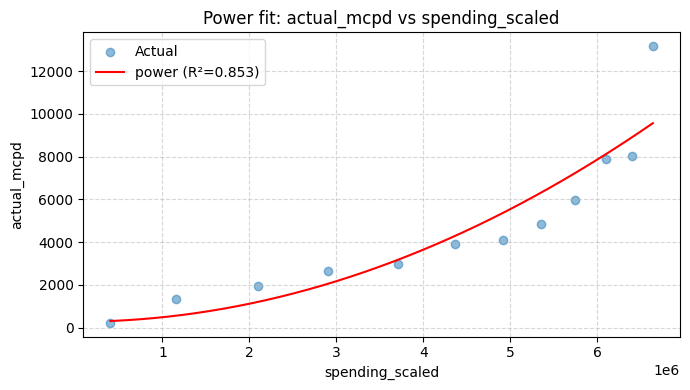


Best Model → power  (R²=0.8528)


In [67]:

# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["power"]

best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
   df_global_weighted[df_global_weighted['spending_scaled'] <= 7000000],
    x_col="spending_scaled",
    y_col="actual_mcpd",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

In [68]:
spending_mcpd_best_kin = best_kind
spending_mcpd_best_formula = best_formula
spending_mcpd_best_r2 = best_r2
spending_mcpd_results_df = results_df
spending_mcpd_best_fit_df = best_fit_df
spending_mcpd_coef_df = coef_df

In [69]:
df_spending_mcpd = best_fit_df.copy()
df_spending_mcpd.head()

,spending_scaled,_pow_x,actual_mcpd
0,402160.293571,1.617329e+11,307.168480
1,414655.504967,1.719392e+11,309.321731
2,427150.716364,1.824577e+11,311.540860
3,439645.927760,1.932885e+11,313.825867
4,452141.139156,2.044316e+11,316.176753


#### mCPD <> mCPIH

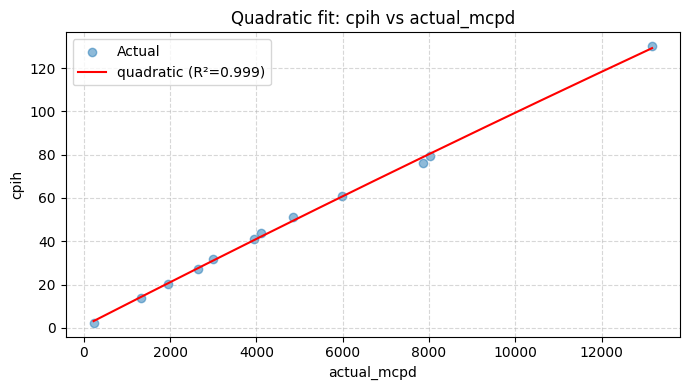


Best Model → quadratic  (R²=0.9985)


In [70]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
    df_global_weighted,
    x_col="actual_mcpd",
    y_col="cpih",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [71]:
mcpd_cpih_best_kin = best_kind
mcpd_cpih_best_formula = best_formula
mcpd_cpih_best_r2 = best_r2
mcpd_cpih_results_df = results_df
mcpd_cpih_best_fit_df = best_fit_df
mcpd_cpih_coef_df = coef_df

In [72]:
df_mpcd_cpih = best_fit_df.copy()
df_mpcd_cpih.head()

,actual_mcpd,_x2,cpih
0,225.802987,50986.988825,3.150551
1,251.746602,63376.351419,3.414682
2,277.690216,77111.856317,3.678766
3,303.633831,92193.503519,3.942804
4,329.577446,108621.293024,4.206796


#### mCPD <> mCPIH Lifetime

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


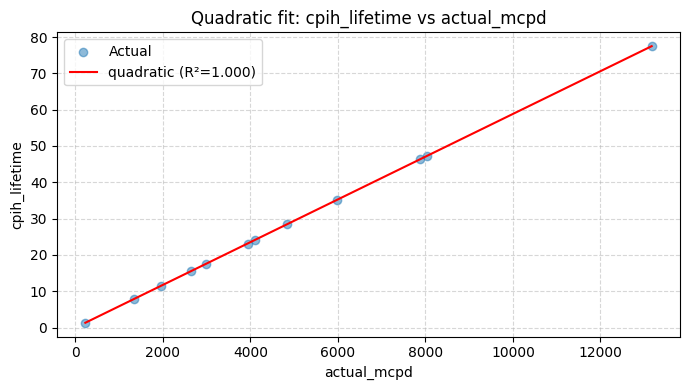


Best Model → quadratic  (R²=1.0000)


In [73]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
    df_global_weighted,
    x_col="actual_mcpd",
    y_col="cpih_lifetime",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [74]:
mcpd_cpih_lifetime_best_kin = best_kind
mcpd_cpih_lifetime_best_formula = best_formula
mcpd_cpih_lifetime_best_r2 = best_r2
mcpd_cpih_lifetime_results_df = results_df
mcpd_cpih_lifetime_best_fit_df = best_fit_df
mcpd_cpih_lifetime_coef_df = coef_df

In [75]:
df_mpcd_cpih_lifetime = best_fit_df.copy()
df_mpcd_cpih_lifetime.head()

,actual_mcpd,_x2,cpih_lifetime
0,225.802987,50986.988825,1.328253
1,251.746602,63376.351419,1.480862
2,277.690216,77111.856317,1.633472
3,303.633831,92193.503519,1.786081
4,329.577446,108621.293024,1.938691


### mCPD <> CPIWAD

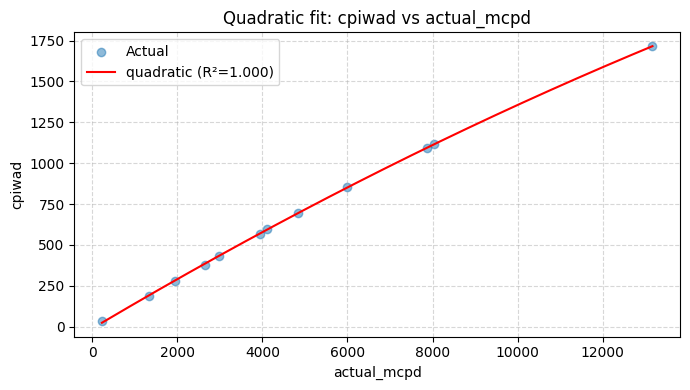


Best Model → quadratic  (R²=0.9999)


,kind,formula,r2,Intercept,_x2,x_col
0,quadratic,cpiwad = -0.0000017679·actual_mcpd² + 0.154·ac...,0.9999,-11.557563,-0.000002,0.154461


In [76]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
    df_global_weighted,
    x_col="actual_mcpd",
    y_col="cpiwad",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

mcpd_cpiwad_coef_df = coef_df
mcpd_cpiwad_coef_df


#### Plot the chart

In [77]:
def pred_formula(s, df):

    if df['kind'][0] == "power":
        
        intercept = df['Intercept'][0]
        _pow_x = df['_pow_x'][0]
        
        return (intercept + _pow_x*s**2)

    elif df['kind'][0] == "quadratic":

        intercep = df['Intercept'][0]
        _x2 = df['_x2'][0]
        x_col = df['x_col'][0]
        
        return (intercep + _x2*s**2 + x_col*s)
    
    else:
        print("not power or quadratic")
        return None

def inverse_model(y, df):
    kind = df['kind'][0]
    
    if kind == "power":
        a = df['_pow_x'][0]
        c = df['Intercept'][0]
        return np.sqrt((y - c) / a)   # only positive root (fits spend-style use case)
    
    elif kind == "quadratic":
        a = df['_x2'][0]
        b = df['x_col'][0]
        c = df['Intercept'][0] - y    # note: intercept - y

        disc = b**2 - 4*a*c
        if disc < 0:
            return np.nan   # no real roots
        roots = [(-b + np.sqrt(disc)) / (2*a),
                 (-b - np.sqrt(disc)) / (2*a)]
        return roots  # return both roots as a list
    
    else:
        return None

In [78]:

spending = np.arange(1000000, 6800001, 200000)

mcpd = pred_formula(spending, spending_mcpd_coef_df)
cpih = pred_formula(mcpd, mcpd_cpih_coef_df)
cpih_lifetime = pred_formula(mcpd, mcpd_cpih_lifetime_coef_df)
cpiwad = pred_formula(mcpd, mcpd_cpiwad_coef_df)

# build dataframe
df_new = pd.DataFrame({
    "spending": spending,
    "mcpd": mcpd,
    "cpih": cpih,
    "cpih_lifetime": cpih_lifetime,
    "cpiwad": cpiwad
})

# for plotting only
mcpd_levels = np.arange(1000, 10000, 1000)
# Exact spending values that produce those MCPD levels
spending_marks = inverse_model(mcpd_levels, spending_mcpd_coef_df)
cpih_marks = pred_formula(mcpd_levels, mcpd_cpih_coef_df)
cpih_lifetime_marks = pred_formula(mcpd_levels, mcpd_cpih_lifetime_coef_df)
cpiwad_marks = pred_formula(mcpd_levels, mcpd_cpiwad_coef_df)

In [79]:
df_new

,spending,mcpd,cpih,cpih_lifetime,cpiwad
0,1000000,484.020170,5.777381,2.847177,62.790397
1,1200000,576.848272,6.720594,3.393225,76.954598
2,1400000,686.554211,7.834534,4.038554,93.654826
3,1600000,813.137986,9.118819,4.783165,112.871442
4,1800000,956.599598,10.573008,5.627056,134.581783
5,2000000,1116.939046,12.196599,6.570230,158.760163
6,2200000,1294.156331,13.989033,7.612684,185.377879
7,2400000,1488.251453,15.949693,8.754420,214.403202
8,2600000,1699.224412,18.077900,9.995438,245.801384
9,2800000,1927.075207,20.372919,11.335737,279.534653


In [80]:
def plot_the_mCPIH_cost_curve(df_new, spending_marks, cpih_marks, cpih_lifetime_marks, mcpd_levels):
    # plot the cost curve
    plt.rcParams.update({
        "figure.dpi": 150,                   # crisp display at normal size
        "savefig.dpi": 300,                  # high-res export
        "font.family": ["Proxima Nova", "Helvetica Neue", "Arial"],
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "--",
        "axes.linewidth": 0.8,              
    })

    colors = {"cpih": "#d19017", "cpih_lifetime": "#0778b5", "dxo": "#038c0a", "dxo_cpih_15": "#403f3e"}

    fig, ax = plt.subplots(figsize=(7, 4))   # regular size

    line1, = ax.plot(df_new["spending"], df_new["cpih"], label="DAC mCPIH (26wks)", color=colors["cpih"], linewidth=1.5, zorder=2)
    line2, = ax.plot(df_new["spending"], df_new["cpih_lifetime"], label="DAC mCPILH (52wks)", color=colors["cpih_lifetime"], linewidth=1.5, zorder=2)
    # line3, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih"], label="DxO CPIH", color=colors["dxo"], linestyle="--", linewidth=1.5, zorder=1)
    # line4, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih_15"], label="DxO CPIH ($15)", color=colors["dxo_cpih_15"], linestyle="--", linewidth=1.5, zorder=1)
    # 5) Tick markers (smaller, same color as lines)
    ax.scatter(spending_marks, cpih_marks, marker='o', s=10, color=colors["cpih"], zorder=3)
    ax.scatter(spending_marks, cpih_lifetime_marks, marker='s', s=10, color=colors["cpih_lifetime"], zorder=3)

    # 6) Annotations (CPIH above, Lifetime below) with subtle halo for readability
    halo = [pe.withStroke(linewidth=2, foreground="white")]
    for s, y, lvl in zip(spending_marks, cpih_marks, mcpd_levels):
        ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih"], path_effects=halo)

    for s, y, lvl in zip(spending_marks, cpih_lifetime_marks, mcpd_levels):
        ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, -9), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih_lifetime"], path_effects=halo)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color("black")

    ax.set_xlabel("Spending")
    ax.set_ylabel("CPIH (CPIHL)")
    # ax.set_title("Global: DAC vs DxO CPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
    ax.set_title("Global: DAC mCPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas on x

    mcpd_handle1 = ax.scatter([], [], marker='o', s=10, color=colors["cpih"], label="mCPD ticks (CPIH)")
    mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
    # mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
    # ax.legend(handles=[line1, line2, line3, line4, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")
    ax.legend(handles=[line1, line2, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")

    fig.tight_layout()
    plt.show()

In [81]:
plot_the_cost_curve(df_new, spending_marks, cpih_marks, cpih_lifetime_marks, mcpd_levels)

NameError: name 'plot_the_cost_curve' is not defined

In [ ]:
def plot_the_mCPIWAD_cost_curve(df_new, spending_marks, cpih_marks, cpih_lifetime_marks, mcpd_levels, cpiwad_marks):
    # plot the cost curve
    plt.rcParams.update({
        "figure.dpi": 150,                   # crisp display at normal size
        "savefig.dpi": 300,                  # high-res export
        "font.family": ["Proxima Nova", "Helvetica Neue", "Arial"],
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "--",
        "axes.linewidth": 0.8,              
    })

    colors = {"cpiwad": "#d19017"}

    fig, ax = plt.subplots(figsize=(7, 4))   # regular size

    line1, = ax.plot(df_new["spending"], df_new["cpiwad"], label="DAC mCPIWAD (26wks)", color=colors["cpiwad"], linewidth=1.5, zorder=2)
    # line2, = ax.plot(df_new["spending"], df_new["cpih_lifetime"], label="DAC mCPILH (52wks)", color=colors["cpih_lifetime"], linewidth=1.5, zorder=2)
    # line3, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih"], label="DxO CPIH", color=colors["dxo"], linestyle="--", linewidth=1.5, zorder=1)
    # line4, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih_15"], label="DxO CPIH ($15)", color=colors["dxo_cpih_15"], linestyle="--", linewidth=1.5, zorder=1)
    # 5) Tick markers (smaller, same color as lines)
    ax.scatter(spending_marks, cpiwad_marks, marker='o', s=10, color=colors["cpiwad"], zorder=3)
    # ax.scatter(spending_marks, cpih_lifetime_marks, marker='s', s=10, color=colors["cpih_lifetime"], zorder=3)

    # 6) Annotations (CPIH above, Lifetime below) with subtle halo for readability
    halo = [pe.withStroke(linewidth=2, foreground="white")]
    for s, y, lvl in zip(spending_marks, cpih_marks, mcpd_levels):
        ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=7, color=colors["cpiwad"], path_effects=halo)

    # for s, y, lvl in zip(spending_marks, cpih_lifetime_marks, mcpd_levels):
        # ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, -9), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih_lifetime"], path_effects=halo)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color("black")

    ax.set_xlabel("Spending")
    ax.set_ylabel("CPIWAD (CPIWAD LT)")
    # ax.set_title("Global: DAC vs DxO CPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
    ax.set_title("Global: DAC mCPIWAD", fontfamily="Arial", fontweight="bold", fontsize = 10)
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas on x

    mcpd_handle1 = ax.scatter([], [], marker='o', s=10, color=colors["cpiwad"], label="mCPD ticks (CPIWAD)")
    # mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
    # mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
    # ax.legend(handles=[line1, line2, line3, line4, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")
    ax.legend(handles=[line1, line2, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")

    fig.tight_layout()
    plt.show()

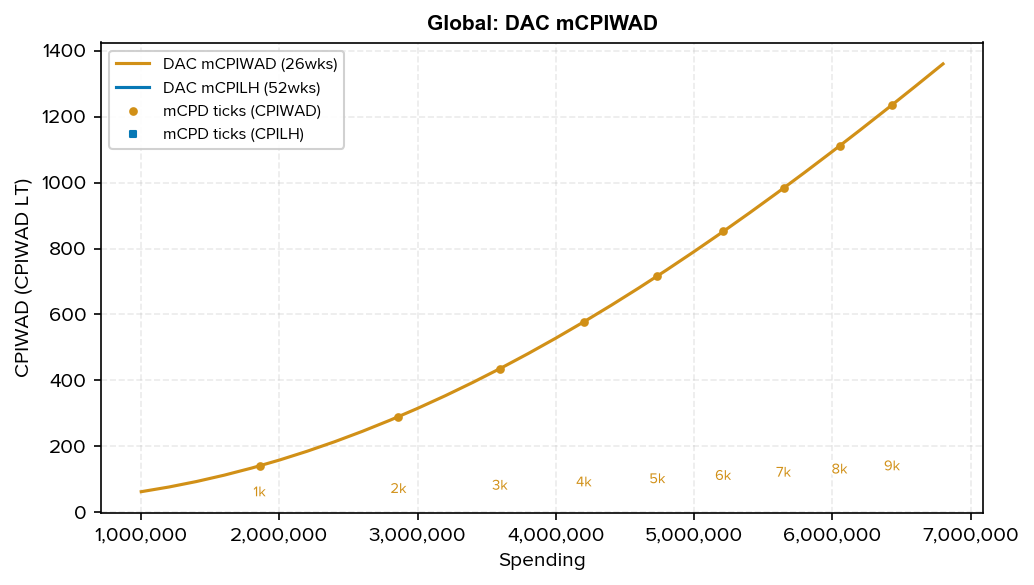

In [ ]:
plot_the_mCPIWAD_cost_curve(df_new, spending_marks, cpih_marks, cpih_lifetime_marks, mcpd_levels, cpiwad_marks)